In [113]:
import os 
import tqdm
import librosa
import numpy as np
from matplotlib import pyplot as plt
import skfda
import math 

from scipy.optimize import minimize


In [114]:
our_files = os.listdir("C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs")
paper_files = os.listdir("C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs-paper")

In [115]:
dic_2 = {file:{'Label':None,
               'MFCC':None} for file in paper_files}

In [141]:
for file in tqdm.tqdm(paper_files):
    path = 'C:/Users/Leonardo/Desktop/UNIVERSITA/MS/I anno/II semestre/SL/FINAL_PROJECT/Nuova cartella/processed-recs-paper/' + file
    audio, _ = librosa.load(path, sr=None)
    dic_2[file]['MFCC'] = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=20, dct_type=2, n_fft=1012, hop_length=256, norm='ortho')
    dic_2[file]['Label'] = float(file.split('_')[3][:-4])

100%|██████████| 333/333 [00:05<00:00, 66.02it/s]


In [143]:
# Functional tool kit

basis = skfda.representation.basis.Fourier(n_basis=40)

def FDA_generator(array):
    points = np.linspace(0,1,len(array))
    fd_obj = skfda.FDataGrid(data_matrix=[array],
                             grid_points=points)
    return fd_obj

# First transform pipeline: retrieve eGFC from the extracted features

def processing(matrix, basis):
    output = np.zeros((np.shape(matrix)[0],basis.n_basis))
    for i in range(0,np.shape(matrix)[0]):
        fda_obj = FDA_generator(matrix[i,])
        output[i,:] = fda_obj.to_basis(basis).coefficients
    return output

In [144]:
design_tensor = np.zeros((20,41,len(dic_2.values())))

for i in tqdm.tqdm(range(len(dic_2.keys()))):
    key = list(dic_2.keys())[i]
    design_tensor[:,:,i] = processing(dic_2[key]['MFCC'],basis)

y_true = np.array([dic_2[key]['Label'] for key in dic_2.keys()])

100%|██████████| 333/333 [00:14<00:00, 22.72it/s]


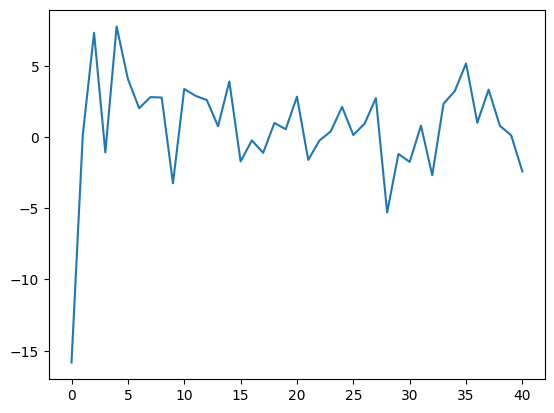

In [146]:
plt.plot(design_tensor[2,:,0])

In [147]:
design_tensor.shape

(20, 41, 333)

In [150]:
# Non-parametric regression on a vectorial functional space 

def K(t):
    return(0.5*np.exp(-0.5*(t**2)))

def L2(x1,x2):
    return np.linalg.norm(x1-x2)

def weightedCompWiseDist(X1,X2,omega):
    L = np.shape(X1)[0]
    D = np.zeros(L)

    for i in range(0,L):
        D[i] = L2(X1[i,:],X2[i,:])
    
    return np.sum(D*omega)

def KR_estimator(x,X,Y,omega):
    weights = np.ones(len(Y))
    for i in range(len(Y)):
        weights[i] = K(weightedCompWiseDist(x,X[:,:,i],omega))
    return np.sum(weights*Y)/np.sum(weights)  

# Minimization problem objective function 

def objective(params):
    omega = params[0:20]
    output = 0
    for i in range(len(y_true)):
        x = design_tensor[:,:,i]
        y = y_true[i]
        _X = design_tensor[:,:,[j for j in range(0,len(y_true)) if j != i]]
        _Y = y_true[[j for j in range(0,len(y_true)) if j != i]]
        pred = KR_estimator(x,_X,_Y,omega)
        output += (pred-y)**2
    return np.sqrt(output/len(y_true))

In [151]:
minimize(objective, x0 = np.array([0.1 for j in range(20)]), options={'maxiter':50}, method='Nelder-Mead')

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 19.21410479191212
             x: [ 8.631e-02  1.077e-01 ...  9.985e-02  9.693e-02]
           nit: 50
          nfev: 74
 final_simplex: (array([[ 8.631e-02,  1.077e-01, ...,  9.985e-02,
                         9.693e-02],
                       [ 8.222e-02,  1.042e-01, ...,  1.018e-01,
                         9.858e-02],
                       ...,
                       [ 9.040e-02,  1.029e-01, ...,  1.049e-01,
                         9.957e-02],
                       [ 9.086e-02,  1.029e-01, ...,  9.915e-02,
                         9.960e-02]]), array([ 1.921e+01,  1.926e+01, ...,  1.943e+01,  1.944e+01]))